In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.utils import split_dataset
from tensorflow.keras.layers import InputLayer,MaxPool2D,Conv2D,Dense,Flatten,BatchNormalization,Input,Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from google.colab import drive

from tensorflow.keras.models import Model

In [ ]:
dataset,dataset_info=tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True,split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.V3DZ9C_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [ ]:

def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset



In [ ]:

TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )

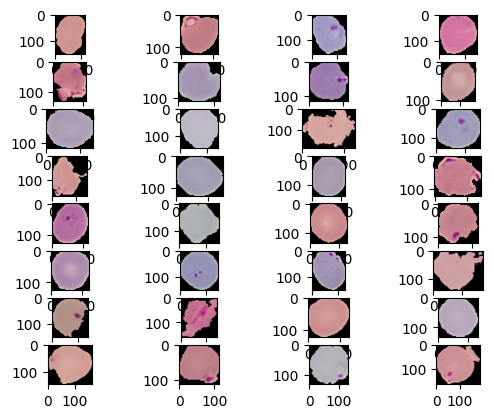

In [ ]:
for i, (image,label) in enumerate(train_dataset.take(32)):
  ax=plt.subplot(8,4,i+1)
  plt.imshow(image)

In [ ]:
IM_SIZE=224
def resizing(image,label):
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0,label

In [ ]:
train_dataset=train_dataset.map(resizing)
val_dataset=val_dataset.map(resizing)
test_dataset=test_dataset.map(resizing)

In [ ]:
for image,label in train_dataset.take(1):
  print (image ,label)


tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
BATCH_SIZE=32
train_dataset=train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_dataset=val_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow import keras
model=tf.keras.Sequential([InputLayer(input_shape =(IM_SIZE,IM_SIZE,3)),
                          Conv2D(filters=6,kernel_size=5,strides=1,padding='valid',activation='relu'),
                           BatchNormalization(),
                          MaxPool2D(pool_size=2,strides=2),
                            Conv2D(filters=16,kernel_size=5,strides=1,padding='valid',activation='relu'),
                         BatchNormalization(),
                           MaxPool2D(pool_size=2,strides=2),
                           Flatten(),


                           Dense(100,activation='relu'),
                           BatchNormalization(),
                             Dense(10,activation='relu'),
                           BatchNormalization(),
                             Dense(1,activation='sigmoid'),

]

)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 batch_normalization (Batch  (None, 220, 220, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_1 (Bat  (None, 106, 106, 16)      64        
 chNormalization)                                                
                                                        

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.1),loss =BinaryCrossentropy(),metrics='accuracy')

In [ ]:
model.fit(train_dataset,validation_data=val_dataset,epochs=3,verbose =1)

Epoch 1/3
689/689 [==============================] - 60s 76ms/step - loss: 0.6322 - accuracy: 0.6434 - val_loss: 3.9608 - val_accuracy: 0.5096
Epoch 2/3
689/689 [==============================] - 44s 64ms/step - loss: 0.2751 - accuracy: 0.9125 - val_loss: 0.2846 - val_accuracy: 0.9332
Epoch 3/3
689/689 [==============================] - 45s 65ms/step - loss: 0.2135 - accuracy: 0.9351 - val_loss: 0.6318 - val_accuracy: 0.8711


In [ ]:
model.evaluate(test_dataset.batch(1))

2757/2757 [==============================] - 21s 4ms/step - loss: 0.6711 - accuracy: 0.8672


[0.6711335182189941, 0.8672469854354858]

In [ ]:
model.predict((test_dataset.batch(1)).take(1))[0][0]

1/1 [==============================] - 11s 11s/step


0.9996555

In [ ]:
model.save("savedmodels.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Funcitonal API##

In [ ]:
func_input= Input(shape=(IM_SIZE,IM_SIZE,3),name="Input Image")



x=Conv2D(filters=6,kernel_size=5,strides=1,padding='valid',activation='relu')(func_input)
x=BatchNormalization()(x)
x=MaxPool2D(pool_size=2,strides=2)(x)
x=Conv2D(filters=16,kernel_size=5,strides=1,padding='valid',activation='relu')(x)
x=BatchNormalization()(x)
x=MaxPool2D(pool_size=2,strides=2)(x)
x=Flatten()(x)


x=Dense(100,activation='relu')(x)
x=BatchNormalization()(x)
x=Dense(10,activation='relu')(x)
x=BatchNormalization()(x)
func_output=Dense(1,activation='sigmoid')(x)


In [ ]:
lenet_model=Model(func_input,func_output,name="LenetModel")

In [ ]:
lenet_model.compile(optimizer=Adam(learning_rate=0.1),loss =BinaryCrossentropy(),metrics='accuracy')

In [ ]:
lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=3,verbose =1)

Epoch 1/3
689/689 [==============================] - 50s 69ms/step - loss: 0.6211 - accuracy: 0.6636 - val_loss: 0.9737 - val_accuracy: 0.6512
Epoch 2/3
689/689 [==============================] - 52s 75ms/step - loss: 0.2744 - accuracy: 0.9040 - val_loss: 0.3304 - val_accuracy: 0.8987
Epoch 3/3
689/689 [==============================] - 43s 63ms/step - loss: 0.2002 - accuracy: 0.9378 - val_loss: 0.2024 - val_accuracy: 0.9336


In [ ]:
func_input= Input(shape=(IM_SIZE,IM_SIZE,3),name="Input Image")



x=Conv2D(filters=6,kernel_size=5,strides=1,padding='valid',activation='relu')(func_input)
x=BatchNormalization()(x)
x=MaxPool2D(pool_size=2,strides=2)(x)
x=Conv2D(filters=16,kernel_size=5,strides=1,padding='valid',activation='relu')(x)
x=BatchNormalization()(x)
x=MaxPool2D(pool_size=2,strides=2)(x)

func_output=Dense(1,activation='sigmoid')(x)
fem=Model(func_input,func_output,name="FeatureExtractor")

In [ ]:
func_input= Input(shape=(IM_SIZE,IM_SIZE,3),name="Input Image")



x=fem(func_input)
x=Flatten()(x)


x=Dense(100,activation='relu')(x)
x=BatchNormalization()(x)
x=Dense(10,activation='relu')(x)
x=BatchNormalization()(x)
func_output=Dense(1,activation='sigmoid')(x)


Custom Layer